<a href="https://colab.research.google.com/github/abagnard/266FinalProject/blob/main/W266_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [267]:
import os, sys, re, csv, json, time, unittest
import itertools, collections
from importlib import reload

import pandas as pd
import numpy as np
from scipy import stats

# Data Scraper Packages
from   bs4    import BeautifulSoup
from   urllib.request import urlopen

# Clean Data Packages
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import glob

# FOMC Data Loader

In [268]:
# Pull Dates of FOMC meetings
df_date = pd.read_csv("data/FOMC_data/FOMC_meeting_dates.csv")
meeting_dates = df_date["MeetingDate"].values.tolist()

## Create DataFrame with Clean Data
- Includes press_conference flag that denotes whether a press conference was held for that FOMC meeting

In [269]:
clean_file_names = glob.glob('data/FOMC_data/FOMC_data_clean/*.txt')

FOMC_records = []
for clean_file_name in clean_file_names:
    meeting_date = clean_file_name.split('/')[-1].split('_')[-1][:-4]
    press_conference = df_date[df_date['MeetingDate'] == int(meeting_date)].iloc[0]['PressConference']
    data = open(clean_file_name).read()
    
    if 'Minutes' in clean_file_name:
        file_type = 'minutes'
        release_date = df_date[df_date['MeetingDate'] == int(meeting_date)].iloc[0]['MinuteNotesReleaseDate']
        # Pull data without stopwords
        file_name = clean_file_name[-24:]
        data_without_stopwords = open('data/FOMC_data/FOMC_data_clean/FOMC_data_clean_without_stopwords/' + file_name).read()
    
    else:
        file_type = 'statement'
        release_date = meeting_date
        # Pull data without stopwords        
        file_name = clean_file_name[-26:]
        data_without_stopwords = open('data/FOMC_data/FOMC_data_clean/FOMC_data_clean_without_stopwords/' + file_name).read()
    
    FOMC_record = {'FOMC_date': meeting_date, 'release_date': release_date, 'document_type': file_type, 'press_conference': press_conference, 'document_data': data, 'document_data_wo_stopwords': data_without_stopwords}
    FOMC_records.append(FOMC_record)


df_FOMC_raw = pd.DataFrame(FOMC_records)

In [270]:
df_FOMC_raw.FOMC_date = pd.to_datetime(df_FOMC_raw.FOMC_date, format='%Y%m%d')
df_FOMC_raw.release_date = pd.to_datetime(df_FOMC_raw.release_date, format='%Y%m%d')

df_FOMC_raw.head()
# df_FOMC_raw.describe(include='all')
# df_FOMC_raw.dtypes

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date
0,2006-01-31,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,minutes,0,2006-02-21
1,2000-10-03,for immediate release the FOMC at its meeting ...,immediate release FOMC meeting today decided m...,statement,0,2000-10-03
2,2000-03-21,for immediate release the FOMC voted today to ...,immediate release FOMC voted today raise targe...,statement,0,2000-03-21
3,2011-01-26,information received since the FOMC met in dec...,information received since FOMC met december c...,statement,0,2011-01-26
4,2002-11-06,for immediate release the FOMC decided today t...,immediate release FOMC decided today lower tar...,statement,0,2002-11-06


In [272]:
df_FOMC_512_raw = df_FOMC_raw

def pull_middle_512_words(data):
    data = data.split(' ')
    midpoint = len(data)//2
    start_idx = midpoint - 200
    end_idx = midpoint + 200
    data_512 = ' '.join(data[start_idx:end_idx])
    return data_512

df_FOMC_512_raw['document_data_512'] = df_FOMC_512_raw['document_data'].apply(lambda data: pull_middle_512_words(data))
df_FOMC_512_raw['document_data_wo_stopwords_512'] = df_FOMC_512_raw['document_data_wo_stopwords'].apply(lambda data: pull_middle_512_words(data))


In [273]:
df_FOMC_512_raw.head()


,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date,document_data_512,document_data_wo_stopwords_512
0,2006-01-31,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,minutes,0,2006-02-21,account messrs oliner and slifman associate di...,messrs moskow poole hoenig alternate members F...
1,2000-10-03,for immediate release the FOMC at its meeting ...,immediate release FOMC meeting today decided m...,statement,0,2000-10-03,utilization of the pool of available workers r...,immediate release FOMC meeting today decided m...
2,2000-03-21,for immediate release the FOMC voted today to ...,immediate release FOMC voted today raise targe...,statement,0,2000-03-21,growth and of the information currently availa...,raise target federal funds rate 25 basis point...
3,2011-01-26,information received since the FOMC met in dec...,information received since FOMC met december c...,statement,0,2011-01-26,levels consistent with its mandate,committee regularly review pace securities pur...
4,2002-11-06,for immediate release the FOMC decided today t...,immediate release FOMC decided today lower tar...,statement,0,2002-11-06,in productivity is providing important ongoing...,immediate release FOMC decided today lower tar...


### Rename Column Names for 512 subselection

In [274]:
df_FOMC_512_raw = df_FOMC_512_raw.drop(['document_data', 'document_data_wo_stopwords'], axis = 1)
df_FOMC_512_raw = df_FOMC_512_raw.rename(columns = {'document_data_512': 'document_data', 'document_data_wo_stopwords_512': 'document_data_wo_stopwords'})

In [275]:
df_FOMC_512_raw.head()

,FOMC_date,document_type,press_conference,release_date,document_data,document_data_wo_stopwords
0,2006-01-31,minutes,0,2006-02-21,account messrs oliner and slifman associate di...,messrs moskow poole hoenig alternate members F...
1,2000-10-03,statement,0,2000-10-03,utilization of the pool of available workers r...,immediate release FOMC meeting today decided m...
2,2000-03-21,statement,0,2000-03-21,growth and of the information currently availa...,raise target federal funds rate 25 basis point...
3,2011-01-26,statement,0,2011-01-26,levels consistent with its mandate,committee regularly review pace securities pur...
4,2002-11-06,statement,0,2002-11-06,in productivity is providing important ongoing...,immediate release FOMC decided today lower tar...


## Add Lables to DataFrame
- Label_Data file includes code on how we caluclate our data lables

In [282]:
# df_market_data_lables = pd.read_csv('data/Market_data/market_data_labels_by_date.csv', parse_dates=['Date'])
df_market_data_lables = pd.read_csv('data/Market_data/label_data_v2.csv', parse_dates=['Date'])

df_market_data_lables.head()
# sns.countplot(df_market_data_lables['label'])
# plt.xlabel('label')

,Unnamed: 0,Date,Press Release,symbol,open,high,low,close,volume,day_before_close,...,prev_fed_rate,pct_change_in_fed_rate,10_yr,one_day_before_10,two_day_before_10,three_day_before_10,prev_days_avg_treas,pct_change_in_treas,label_market,label_FED
0,0,1993-02-03,0,SP500,442.56,447.35,442.56,447.20,345410000,409.53,...,3.08,-15.584416,6.45,7.36,9.01,8.21,8.193333,-27.028424,0,-1
1,1,1993-03-23,0,SP500,448.88,449.80,448.30,448.76,232730000,409.91,...,2.92,-0.342466,5.91,7.62,8.52,9.43,8.523333,-44.218838,0,-1
2,2,1993-05-18,0,SP500,440.39,441.26,437.95,440.32,264300000,412.81,...,2.94,-1.020408,6.15,7.28,8.75,8.78,8.270000,-34.471545,0,-1
3,3,1993-07-07,0,SP500,441.40,443.63,441.40,442.83,253170000,409.16,...,3.09,-9.708738,5.80,6.87,8.02,8.95,7.946667,-37.011494,0,-1
4,4,1993-08-17,0,SP500,452.38,453.70,451.96,453.13,261320000,420.74,...,3.02,-2.649007,5.70,6.56,8.80,8.18,7.846667,-37.660819,0,-1


In [329]:
df_FOMC_labeled =  pd.merge(df_FOMC_512_raw, df_market_data_lables, left_on='FOMC_date', right_on='Date')


In [330]:
df_FOMC_labeled.head()

,FOMC_date,document_type,press_conference,release_date,document_data,document_data_wo_stopwords,Unnamed: 0,Date,Press Release,symbol,...,prev_fed_rate,pct_change_in_fed_rate,10_yr,one_day_before_10,two_day_before_10,three_day_before_10,prev_days_avg_treas,pct_change_in_treas,label_market,label_FED
0,2006-01-31,minutes,0,2006-02-21,account messrs oliner and slifman associate di...,messrs moskow poole hoenig alternate members F...,104,2006-01-31,0,SP500,...,4.47,0.000000,4.53,4.14,4.00,5.07,4.403333,2.796174,0,0
1,2006-01-31,statement,0,2006-01-31,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,104,2006-01-31,0,SP500,...,4.47,0.000000,4.53,4.14,4.00,5.07,4.403333,2.796174,0,0
2,2000-10-03,statement,0,2000-10-03,utilization of the pool of available workers r...,immediate release FOMC meeting today decided m...,61,2000-10-03,0,SP500,...,6.51,0.768049,5.87,6.01,6.61,6.13,6.250000,-6.473595,-1,1
3,2000-10-03,minutes,0,2000-11-16,indexes of stock market prices declined somewh...,though previous policy tightening actions yet ...,61,2000-10-03,0,SP500,...,6.51,0.768049,5.87,6.01,6.61,6.13,6.250000,-6.473595,-1,1
4,2000-03-21,statement,0,2000-03-21,growth and of the information currently availa...,raise target federal funds rate 25 basis point...,57,2000-03-21,0,SP500,...,6.02,3.488372,6.13,6.74,6.28,7.16,6.726667,-9.733551,-1,1


In [331]:
df_FOMC_labeled_small = df_FOMC_labeled[['FOMC_date', 'document_data', 'document_data_wo_stopwords','document_type', 'press_conference', 'release_date','label_market', 'label_FED']].copy()
df_FOMC = df_FOMC_labeled_small
df_FOMC.head()

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date,label_market,label_FED
0,2006-01-31,account messrs oliner and slifman associate di...,messrs moskow poole hoenig alternate members F...,minutes,0,2006-02-21,0,0
1,2006-01-31,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,statement,0,2006-01-31,0,0
2,2000-10-03,utilization of the pool of available workers r...,immediate release FOMC meeting today decided m...,statement,0,2000-10-03,-1,1
3,2000-10-03,indexes of stock market prices declined somewh...,though previous policy tightening actions yet ...,minutes,0,2000-11-16,-1,1
4,2000-03-21,growth and of the information currently availa...,raise target federal funds rate 25 basis point...,statement,0,2000-03-21,-1,1


#### Add Label Each Document Based Original Label

In [388]:
def calcSentimentLabel(score):
    label = 'neutral'
    
    if score == -1:
        label = 'negative'
    elif score == 1:
        label = 'positive'
        
    return label



# df_FOMC['score_FED'] = df_FOMC['label_FED']
# df_FOMC['score_market'] = df_FOMC['label_market']
# df_FOMC['label_FED'] = df_FOMC['score_FED'].apply(lambda score: calcSentimentLabel(score))
# df_FOMC['label_market'] = df_FOMC['score_market'].apply(lambda score: calcSentimentLabel(score))
print(df_FOMC_labeled.describe())

       press_conference  Unnamed: 0  Press Release         open         high  \
count        400.000000  400.000000     400.000000   400.000000   400.000000   
mean           0.227500  118.620000       0.227500  1483.040650  1494.667500   
std            0.419743   61.115861       0.419743   692.955284   694.688365   
min            0.000000    0.000000       0.000000   440.390000   441.260000   
25%            0.000000   69.750000       0.000000  1071.842500  1079.872500   
50%            0.000000  121.000000       0.000000  1298.545000  1308.205000   
75%            0.000000  171.000000       0.000000  1902.520000  1916.990000   
max            1.000000  221.000000       1.000000  3485.740000  3529.050000   

               low        close        volume  day_before_close  \
count   400.000000   400.000000  4.000000e+02        400.000000   
mean   1474.643550  1485.423850  1.881791e+09       1372.529950   
std     689.285368   690.954251  1.675263e+09        624.516533   
min     437

positive    167
negative    125
neutral     108
Name: label_FED, dtype: int64


Text(0.5, 0, 'label_FED')

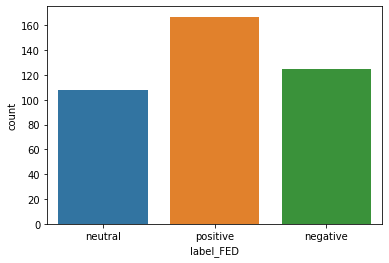

In [333]:
print(df_FOMC['label_FED'].value_counts())
sns.countplot(df_FOMC['label_FED'])
plt.xlabel('label_FED')


neutral     255
negative    125
positive     20
Name: label_market, dtype: int64


Text(0.5, 0, 'label_market')

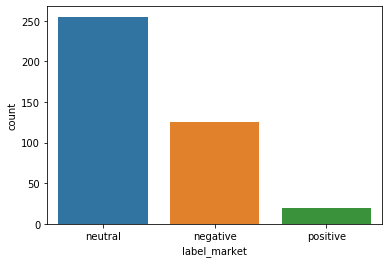

In [334]:
print(df_FOMC['label_market'].value_counts())
sns.countplot(df_FOMC['label_market'])
plt.xlabel('label_market')

Text(0.5, 1.0, 'Statement Lable Counts')

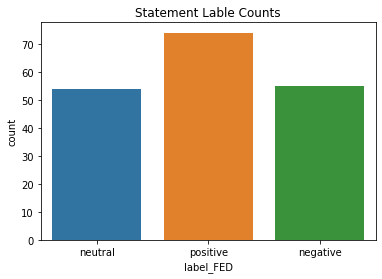

In [335]:
sns.countplot(df_FOMC[df_FOMC['document_type'] == 'statement']['label_FED'])
plt.xlabel('label_FED')
plt.title('Statement Lable Counts')

Text(0.5, 1.0, 'Minutes Lable Counts')

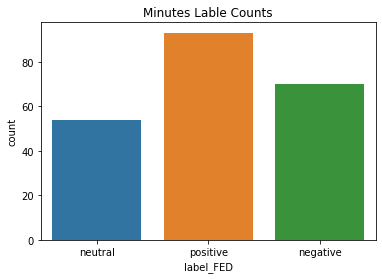

In [336]:
sns.countplot(df_FOMC[df_FOMC['document_type'] == 'minutes']['label_FED'])
plt.xlabel('label_FED')
plt.title('Minutes Lable Counts')

# Top 20 Most Common Words

In [337]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 20)

# ALL Documents
cv.fit(df_FOMC['document_data_wo_stopwords'])
top_20_words_all = cv.get_feature_names()

top_20_words_all = pd.DataFrame(top_20_words_all)
top_20_words_all.columns = ['Top 20 Words']
top_20_words_all['top_word_ranking'] = top_20_words_all.reset_index().index
top_20_words_all

# Statements Only
statements = df_FOMC[df_FOMC['document_type'] == 'statement']
cv.fit(statements['document_data_wo_stopwords'])
top_20_words_statement = cv.get_feature_names()

top_20_words_statement = pd.DataFrame(top_20_words_statement)
top_20_words_statement.columns = ['Statment Top 20 Words']
top_20_words_statement['top_word_ranking'] = top_20_words_statement.reset_index().index
top_20_words_statement

# Minutes Only
minutes = df_FOMC[df_FOMC['document_type'] == 'minutes']
cv.fit(minutes['document_data_wo_stopwords'])
top_20_words_minutes = cv.get_feature_names()

top_20_words_minutes = pd.DataFrame(top_20_words_minutes)
top_20_words_minutes.columns = ['Minutes Top 20 Words']
top_20_words_minutes['top_word_ranking'] = top_20_words_minutes.reset_index().index
top_20_words_minutes

column_names = ['top_word_ranking', 'Top 20 Words', 'Statment Top 20 Words','Minutes Top 20 Words']

# top_20 = pd.DataFrame(results.toarray(). columns=features)
top_20_words_all.merge(top_20_words_statement, left_on='top_word_ranking', right_on='top_word_ranking').merge(top_20_words_minutes, left_on='top_word_ranking', right_on='top_word_ranking')[column_names]

,top_word_ranking,Top 20 Words,Statment Top 20 Words,Minutes Top 20 Words
0,0,activity,committee,activity
1,1,business,conditions,business
2,2,committee,economic,consumer
3,3,conditions,federal,continued
4,4,consumer,financial,economic
5,5,continued,funds,expected
6,6,economic,growth,growth
7,7,expected,inflation,inflation
8,8,federal,labor,market
9,9,growth,longer,pace


# FOMC Word Cloud

### FOMC Statements & Minutes Word Cloud

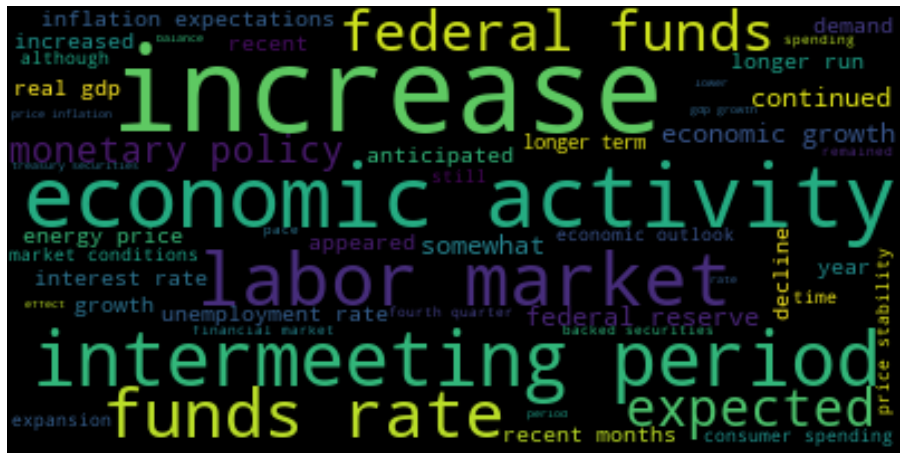

In [338]:
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

text = ' '.join(df_FOMC['document_data_wo_stopwords'])
wordcloud = WordCloud(max_words=50).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/all_FOMC_docs_wordcloud.png")

### FOMC Statements Word Cloud

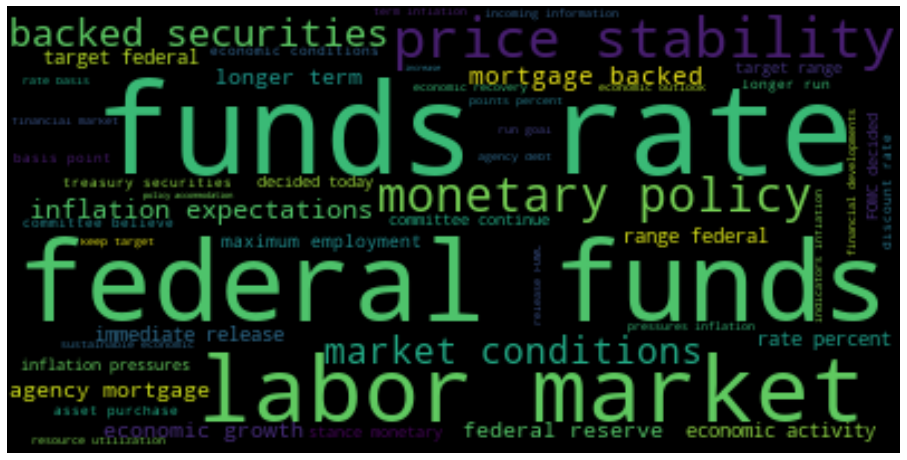

In [339]:
statements = df_FOMC[df_FOMC['document_type'] == 'statement']

plt.figure(figsize=(16, 10))

statement_text = ' '.join(statements['document_data_wo_stopwords'])
statement_wordcloud = WordCloud(max_words=50).generate(statement_text)
plt.imshow(statement_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_statements_wordcloud.png")

### FOMC Minutes Word Cloud

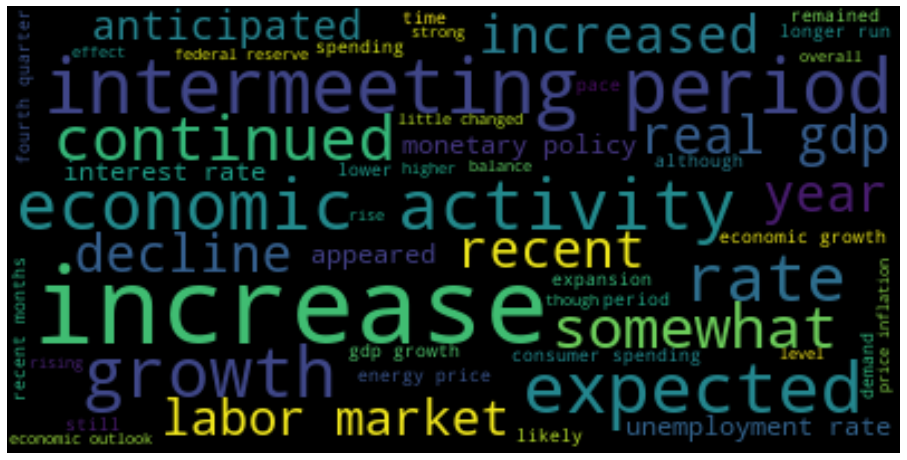

In [340]:
minutes = df_FOMC[df_FOMC['document_type'] == 'minutes']

plt.figure(figsize=(16, 10))

minute_text = ' '.join(minutes['document_data_wo_stopwords'])
minute_wordcloud = WordCloud(max_words=50).generate(minute_text)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(minute_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

# Document Sentiment Analysis

#### Load Loughran-McDonald Postive & Negative Word Lists
source: https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists

In [386]:
# df_FOMC_sentiment = df_FOMC
df_FOMC_sentiment.describe()

,press_conference,score_FED,score_market,LM_sentiment_score,score_LM,score_FinBERT
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.227500,2.105000,1.737500,-1.690000,0.845000,1.300000
std,0.419743,0.848986,0.542521,5.332917,0.814022,0.641114
min,0.000000,1.000000,1.000000,-18.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,-4.000000,0.000000,1.000000
50%,0.000000,2.000000,2.000000,-1.000000,1.000000,1.000000
75%,0.000000,3.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,3.000000,3.000000,10.000000,2.000000,2.000000


In [342]:
def createLoughranMcDonaldWordList(file_name):
    file = open('data/LoughranMcDonald/'+file_name, "r")
    words = file.readlines()
    words = [word.strip().lower() for word in words]
    return words

LM_negative_words = createLoughranMcDonaldWordList('LoughranMcDonald_NegativeWordList.csv')
LM_postive_words = createLoughranMcDonaldWordList('LoughranMcDonald_PositiveWordList.csv')

#### Count Positive and Negative Words in Each Document to Calculate Sentiment Score

In [343]:
def calcSentiment(document_data):
    words = document_data.split(' ')
    positive_words = [word for word in words if word in LM_postive_words]
    negative_words = [word for word in words if word in LM_negative_words]
    positive_count = len(positive_words)
    negative_count = len(negative_words)
    LM_sentiment_score = (positive_count) - negative_count
    return [LM_sentiment_score, positive_count, negative_count, positive_words, negative_words]

# df_FOMC_sentiment['num_LM_positive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[1])
# df_FOMC_sentiment['num_LM_negative_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[2])
df_FOMC_sentiment['LM_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[0])
df_FOMC_sentiment['LM_positive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[3])
df_FOMC_sentiment['LM_netagive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[4])

#### Add Label Each Document Based on Sentiment Score

In [344]:
def calcLMSentimentLabel(LM_sentiment_score):
    LM_sentiment_label = 'neutral'
    
    if LM_sentiment_score < -1:
        LM_sentiment_label = 'negative'
    elif LM_sentiment_score > 1:
        LM_sentiment_label = 'positive'
        
    return LM_sentiment_label
    
df_FOMC_sentiment['LM_sentiment_label'] = df_FOMC_sentiment['LM_sentiment_score'].apply(lambda score: calcLMSentimentLabel(score))



In [345]:
df_FOMC_sentiment.sort_values(['FOMC_date', 'document_type']).head()

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date,label_market,label_FED,score_FED,score_market,LM_sentiment_score,LM_positive_words,LM_netagive_words,LM_sentiment_label
382,1993-02-03,and long term rates including those on fixed r...,total compensation year whole considerably sma...,minutes,0,1993-03-26,neutral,negative,-1,0,-14,"[gains, attractiveness]","[declines, deficit, against, declines, easing,...",negative
178,1993-03-23,of a sustained upturn for now however the favo...,gradual decline unemployment expansion appeare...,minutes,0,1993-05-21,neutral,negative,-1,0,0,"[upturn, favorable, gains, positive, strength,...","[absence, depressed, caution, recalls, decline...",neutral
159,1993-05-18,substantial uncertainty stemming to an importa...,stimulus initiative seemed unlikely enacted co...,minutes,0,1993-07-09,neutral,negative,-1,0,-9,"[gains, improvement, despite, encouraged]","[deficit, concern, worsening, premature, detri...",negative
396,1993-07-07,in recent months as homebuyers tended to remai...,least members appeared reflect previously post...,minutes,0,1993-08-20,neutral,negative,-1,0,-7,"[strengthen, positive, despite, favorable, suc...","[difficulties, weak, declined, weak, worsened,...",negative
378,1993-08-17,activity despite widespread indications of pes...,m3 declined little slightly annual range total...,minutes,0,1993-09-24,neutral,negative,-1,0,-8,"[despite, favorable, improved, better, encoura...","[deficit, against, cautioned, overstated, over...",negative


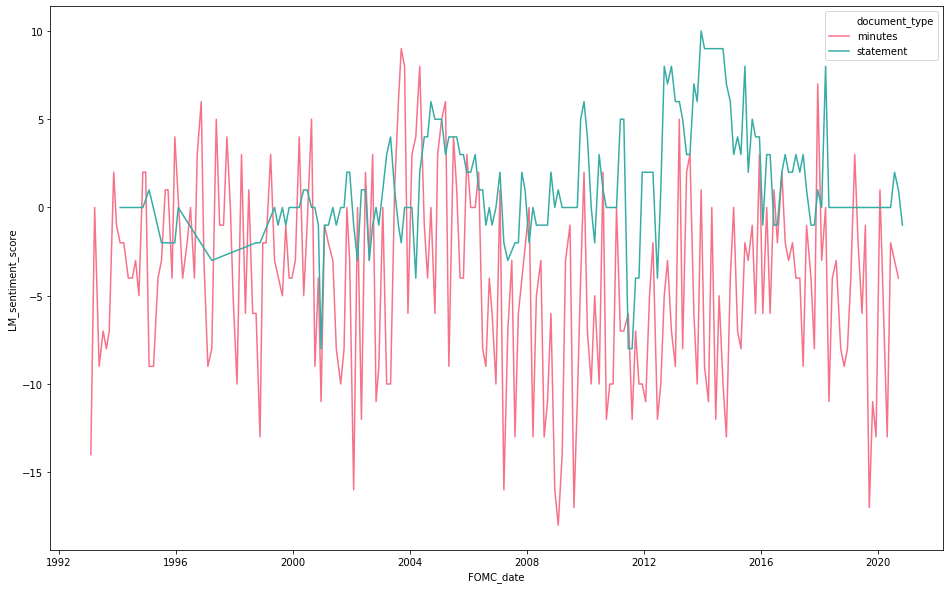

In [346]:
import seaborn as sns
colors = sns.color_palette('husl', n_colors =2)
color_map = dict(zip(['minutes','statement'], colors))

plt.figure(figsize=(16, 10))
sns.lineplot(x=df_FOMC_sentiment['FOMC_date'], y=df_FOMC_sentiment['LM_sentiment_score'], hue=df_FOMC['document_type'], palette=color_map)


In [347]:
df_FOMC_sentiment['LM_sentiment_label'].value_counts()

negative    168
neutral     126
positive    106
Name: LM_sentiment_label, dtype: int64

Text(0.5, 0, 'LM_sentiment_label')

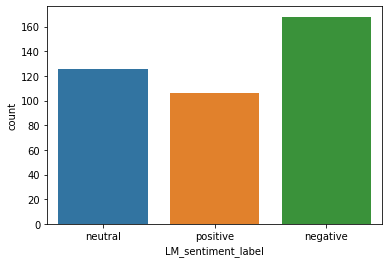

In [348]:
sns.countplot(df_FOMC_sentiment['LM_sentiment_label'])
plt.xlabel('LM_sentiment_label')

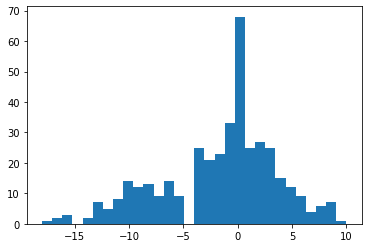

In [349]:
plt.hist(df_FOMC_sentiment['LM_sentiment_score'],  30)
plt.show()


In [350]:
df_FOMC_sentiment['LM_sentiment_label'].value_counts()

negative    168
neutral     126
positive    106
Name: LM_sentiment_label, dtype: int64

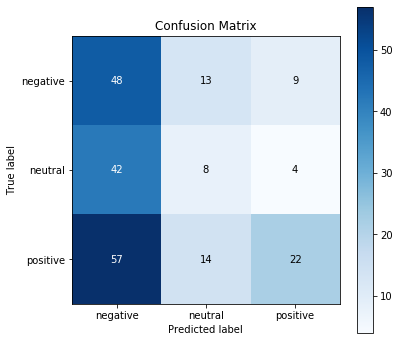

In [402]:
# !pip install scikit-plot
import scikitplot as skplt
minutes = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'minutes']

true_label = minutes['label_FED']
predicted_label = minutes['LM_sentiment_label']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

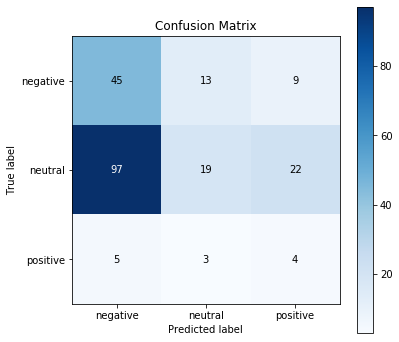

In [401]:
# !pip install scikit-plot
import scikitplot as skplt

true_label = minutes['label_market']
predicted_label = minutes['LM_sentiment_label']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

### Correlation Between Label and LM Sentiment Label

In [405]:
data_label = df_FOMC_sentiment['label_market'].astype('category').cat.codes
LM_sentiment_label = df_FOMC_sentiment['LM_sentiment_label'].astype('category').cat.codes

correlation = data_label.corr(LM_sentiment_label) 

print('Correlation Between LM Sentiment and FinBERT Pretrained Sentiment')
print(correlation)

Correlation Between LM Sentiment and FinBERT Pretrained Sentiment
0.073567488075087


### FOMC Statement Positive + Negative Words Only Word Cloud

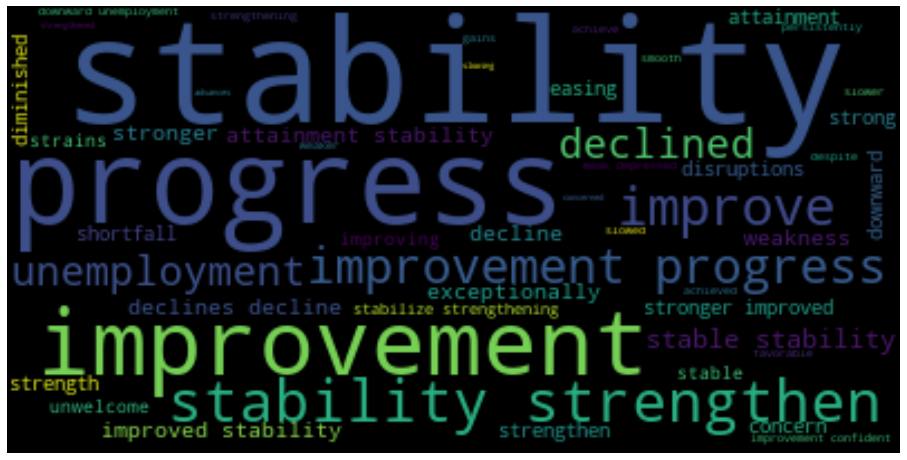

In [353]:
statement = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'statement']

plt.figure(figsize=(16, 10))

positive_words = ' '.join(statement['LM_positive_words'].apply(lambda words: ' '.join(words)))
negative_words = ' '.join(statement['LM_netagive_words'].apply(lambda words: ' '.join(words)))
words = positive_words + negative_words
words_wordcloud = WordCloud(max_words=50).generate(words)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(words_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

### FOMC Minutes Positive + Negative Words Only Word Cloud

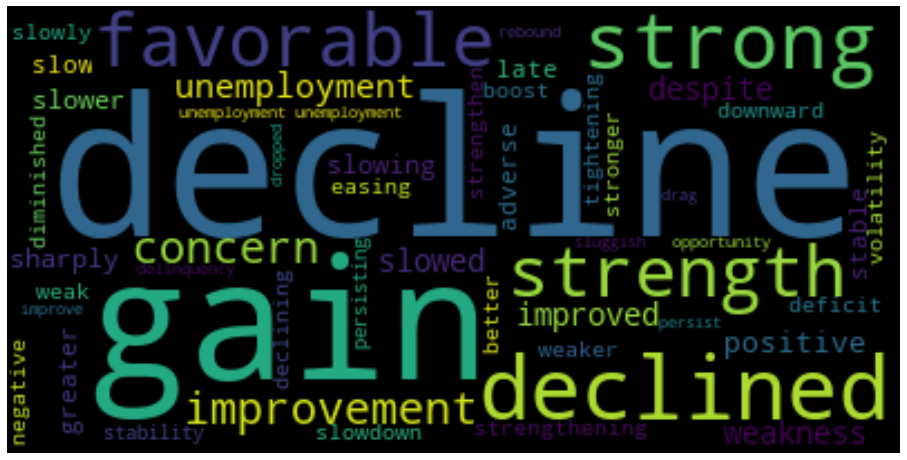

In [354]:
minutes = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'minutes']

plt.figure(figsize=(16, 10))

positive_words = ' '.join(minutes['LM_positive_words'].apply(lambda words: ' '.join(words)))
negative_words = ' '.join(minutes['LM_netagive_words'].apply(lambda words: ' '.join(words)))
words = positive_words + negative_words
words_wordcloud = WordCloud(max_words=50).generate(words)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(words_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

# Pretrained FinBERT Sentiment Analysis

In [357]:
## Load required packages
# pip install torch torchvision
# pip install torch==1.7.0 -f https://download.pytorch.org/whl/torch_stable.html

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# import numpy as np

In [358]:
## Downloads pretrained finBERT model

tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

In [359]:
def finBERTModelPreTrained(review_text):
    MAX_LEN = 512
    class_names = ['negative', 'neutral', 'positive']

    encoded_new = tokenizer.encode_plus(
                            review_text,                      # Sentence to encode.
                            add_special_tokens = True,        # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LEN,             # Pad & truncate all sentences.
                            padding = 'longest',
                            truncation=True,
                            return_attention_mask = True,     # Construct attn. masks.
                            return_tensors = 'pt',            # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    input_idst = (encoded_new['input_ids'])
    attention_maskst = (encoded_new['attention_mask'])

    # Convert the lists into tensors.
    input_idst = torch.cat([input_idst], dim=0)
    attention_maskst = torch.cat([attention_maskst], dim=0)

    new_test_output = model(input_idst, token_type_ids=None, 
                          attention_mask=attention_maskst)

    logits = new_test_output[0]
    predicted = logits.detach().numpy()

    # Store predictions
    flat_predictions = np.concatenate(predicted, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    new_predictions = np.argmax(flat_predictions).flatten()

    return class_names[new_predictions[0]]

### Pretrained FinBERT Model on Entire Document

In [360]:
df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: finBERTModelPreTrained(data))



In [387]:
# df_FOMC_sentiment.groupby(['document_type', 'FinBERT_pretrained_sentiment_score', 'label']).count()
df_FOMC_sentiment.groupby(['document_type', 'LM_sentiment_label', 'FinBERT_pretrained_sentiment_score']).count()
df_FOMC_sentiment.describe()

,press_conference,score_FED,score_market,LM_sentiment_score,score_LM,score_FinBERT
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.227500,2.105000,1.737500,-1.690000,0.845000,1.300000
std,0.419743,0.848986,0.542521,5.332917,0.814022,0.641114
min,0.000000,1.000000,1.000000,-18.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,-4.000000,0.000000,1.000000
50%,0.000000,2.000000,2.000000,-1.000000,1.000000,1.000000
75%,0.000000,3.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,3.000000,3.000000,10.000000,2.000000,2.000000


In [362]:
df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'].value_counts()

neutral     200
positive    160
negative     40
Name: FinBERT_pretrained_sentiment_score, dtype: int64

Text(0.5, 0, 'FinBERT_pretrained_sentiment_score')

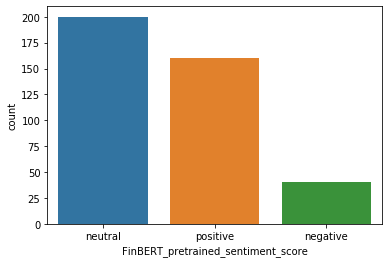

In [363]:
sns.countplot(df_FOMC_sentiment['FinBERT_pretrained_sentiment_score'])
plt.xlabel('FinBERT_pretrained_sentiment_score')

In [364]:
df_FOMC_sentiment['LM_sentiment_label'].value_counts()

negative    168
neutral     126
positive    106
Name: LM_sentiment_label, dtype: int64

Text(0.5, 0, 'LM_sentiment_label')

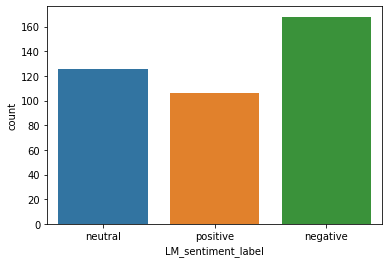

In [365]:
sns.countplot(df_FOMC_sentiment['LM_sentiment_label'])
plt.xlabel('LM_sentiment_label')

### Confusion Matrix Between Fed Label and Pretrained FinBERT Model Sentiment Label

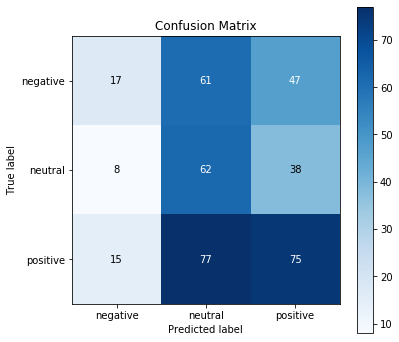

In [366]:
# !pip install scikit-plot
import scikitplot as skplt

true_label = df_FOMC_sentiment['label_FED']
predicted_label = df_FOMC_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

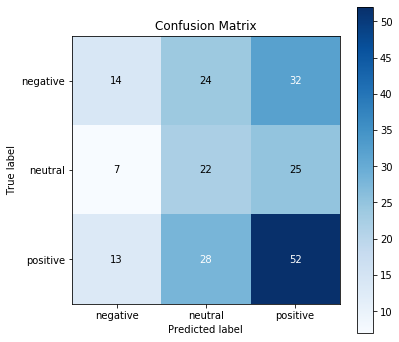

In [399]:
minutes_sentiment = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'minutes']
true_label = minutes_sentiment['label_FED']
predicted_label = minutes_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

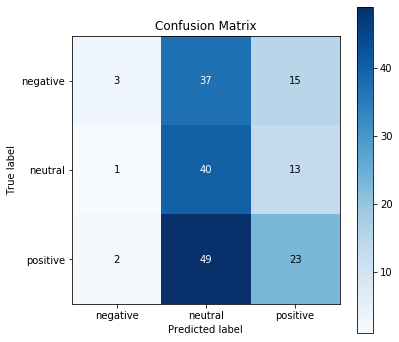

In [368]:
statement_sentiment = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'statement']
true_label = statement_sentiment['label_FED']
predicted_label = statement_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

### Confusion Matrix Between LM Sentiment Label and Pretrained FinBERT Model Sentiment Label

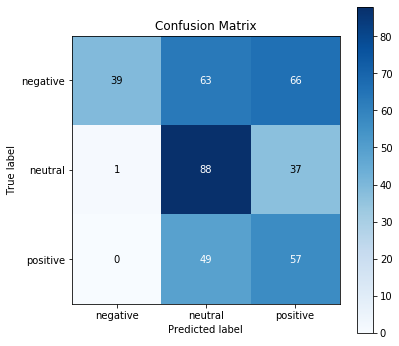

In [369]:
# !pip install scikit-plot
import scikitplot as skplt

true_label = df_FOMC_sentiment['LM_sentiment_label']
predicted_label = df_FOMC_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

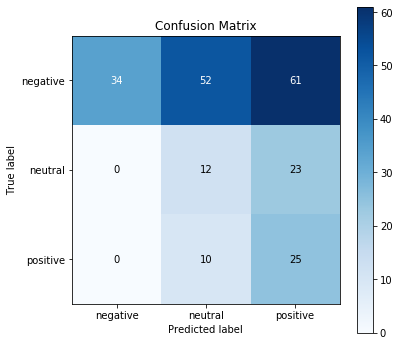

In [398]:
minutes_sentiment = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'minutes']
true_label = minutes_sentiment['LM_sentiment_label']
predicted_label = minutes_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

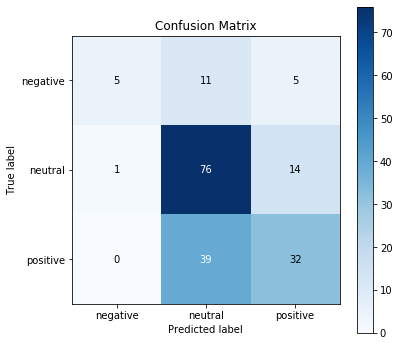

In [372]:
statement_sentiment = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'statement']
true_label = statement_sentiment['LM_sentiment_label']
predicted_label = statement_sentiment['FinBERT_pretrained_sentiment_score']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

In [373]:
df_FOMC_sentiment.head()

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date,label_market,label_FED,score_FED,score_market,LM_sentiment_score,LM_positive_words,LM_netagive_words,LM_sentiment_label,FinBERT_pretrained_sentiment_score
0,2006-01-31,account messrs oliner and slifman associate di...,messrs moskow poole hoenig alternate members F...,minutes,0,2006-02-21,neutral,neutral,0,0,0,[],[],neutral,neutral
1,2006-01-31,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,statement,0,2006-01-31,neutral,neutral,0,0,2,"[attainment, stability]",[],positive,neutral
2,2000-10-03,utilization of the pool of available workers r...,immediate release FOMC meeting today decided m...,statement,0,2000-10-03,negative,positive,1,-1,0,"[conducive, stability]","[poses, against]",neutral,neutral
3,2000-10-03,indexes of stock market prices declined somewh...,though previous policy tightening actions yet ...,minutes,0,2000-11-16,negative,positive,1,-1,-9,"[despite, gains, opportunity, positive, gains]","[declined, against, tightening, negative, conc...",negative,positive
4,2000-03-21,growth and of the information currently availa...,raise target federal funds rate 25 basis point...,statement,0,2000-03-21,negative,positive,1,-1,0,[],[],neutral,neutral


In [375]:
def update_label_to_num(str):
    if(str=='positive'):
        return 2
    elif(str=='neutral'):
        return 1
    else:
        return 0

df_FOMC_sentiment_test = df_FOMC_sentiment
    
df_FOMC_sentiment_test['score_LM'] = df_FOMC_sentiment_test['LM_sentiment_label'].apply(update_label_to_num)
df_FOMC_sentiment_test['score_FinBERT'] = df_FOMC_sentiment_test['FinBERT_pretrained_sentiment_score'].apply(update_label_to_num)
df_FOMC_sentiment_test['score_FED'] = df_FOMC_sentiment_test['score_FED'] + 1
df_FOMC_sentiment_test['score_market'] = df_FOMC_sentiment_test['score_market'] + 1


true = df_FOMC_sentiment_test['score_LM'].tolist()
predicted = df_FOMC_sentiment_test['score_FinBERT'].tolist()


In [376]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
mat = sklearn.metrics.confusion_matrix(true , predicted)
mat


array([[39, 63, 66],
       [ 1, 88, 37],
       [ 0, 49, 57]])

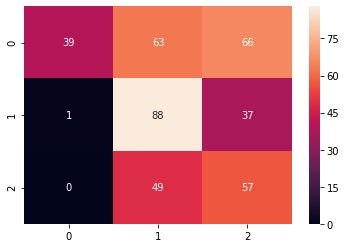

In [377]:
df_cm = pd.DataFrame(mat, range(3), range(3))

sns.heatmap(df_cm, annot=True) 
plt.show()

In [378]:
print(sklearn.metrics.classification_report(true,predicted,target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.97      0.23      0.38       168
     neutral       0.44      0.70      0.54       126
    positive       0.36      0.54      0.43       106

    accuracy                           0.46       400
   macro avg       0.59      0.49      0.45       400
weighted avg       0.64      0.46      0.44       400



In [389]:
sklearn.metrics.accuracy_score(true,predicted)

0.46

In [392]:
# df_FOMC_sentiment['score_market'] = df_FOMC_sentiment['score_market'] -1 
# df_FOMC_sentiment['score_FED'] = df_FOMC_sentiment['score_FED'] -1 
df_FOMC_sentiment.describe()

,press_conference,score_FED,score_market,LM_sentiment_score,score_LM,score_FinBERT
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.227500,1.105000,0.737500,-1.690000,0.845000,1.300000
std,0.419743,0.848986,0.542521,5.332917,0.814022,0.641114
min,0.000000,0.000000,0.000000,-18.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-4.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,-1.000000,1.000000,1.000000
75%,0.000000,2.000000,1.000000,2.000000,2.000000,2.000000
max,1.000000,2.000000,2.000000,10.000000,2.000000,2.000000


# Create CSV of df_FOMC_sentiment for Colab

In [395]:
smaller_df = df_FOMC_sentiment[['FOMC_date', 'document_data', 'document_type', 'press_conference','release_date', 'score_FED', 'score_market','score_LM','score_FinBERT']]
# smaller_df.head()
smaller_df.describe()
smaller_df.to_csv("data_for_colab.csv")


# FinBERT Sentiment Analysis

In [80]:
# pip install pytorch_pretrained_bert
# pip install finbert-embedding==0.1.4

In [79]:
# from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE
# from pytorch_pretrained_bert.modeling import BertForSequenceClassification
# from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert.optimization import *

# from finbert_embedding.embedding import *

In [148]:
# WATCH VIDEO
# https://towardsdatascience.com/how-nlp-has-evolved-for-financial-sentiment-analysis-fb2990d9b3ed

In [149]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [152]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [186]:
model = BertForSequenceClassification.from_pretrained('finBERT/pytorch_model.bin', config = 'finBERT/config.json', num_labels = 3)

label_lists = ['positive', 'negative', 'neutral']

# RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
# 	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
# 	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
    # FIX: add num_labels=3 to the parameters above

### Simple Tests for Accuracy

In [182]:
# TESTS
inputs = tokenizer("We had a good year", return_tensors="pt")
outputs = model(**inputs)
outputs
# Ouputs = [positive, negative, neutral]

label_lists[torch.argmax(outputs[0])]

'positive'

In [184]:
# TESTS
inputs = tokenizer("We had a bad year", return_tensors="pt")
outputs = model(**inputs)
label_lists[torch.argmax(outputs[0])]

'negative'

In [187]:
# TESTS
inputs = tokenizer("We had a neutral year", return_tensors="pt")
outputs = model(**inputs)
label_lists[torch.argmax(outputs[0])]

'neutral'

### Run Data through Model

In [193]:
def runFinBERT(document):
    inputs = tokenizer(document, return_tensors="pt", truncation = True, max_length = 512)
    outputs = model(**inputs)
    return label_lists[torch.argmax(outputs[0])]

In [194]:
df_FOMC_sentiment['FinBERT_video_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: runFinBERT(data))

# RuntimeError: The size of tensor a (5261) must match the size of tensor b (512) at non-singleton dimension 1
    # too many tokens in data...need to truncate or shorten the data into smaller subsections of length 512 and less
    # if you truncate, you need to add truncation = True and max_length = 512 as a parameter in your tokenizer 

In [196]:
df_FOMC_sentiment.groupby(['document_type', 'FinBERT_video_sentiment_score','FinBERT_pretrained_sentiment_score', 'label']).count()

# loss = outputs.loss
# logits = outputs.logits

FOMC_date  \
document_type FinBERT_video_sentiment_score FinBERT_pretrained_sentiment_score label              
minutes       neutral                       neutral                            -3             3   
                                                                               -2            20   
                                                                               -1             7   
                                                                                0            23   
                                                                                1             6   
                                                                                2            25   
                                                                                3             2   
statement     neutral                       negative                           -3             1   
                                                                               -1             1   
                                                                                0             1   
                                            neutral                            -3             2   
                                                                               -2             9   
                                                                               -1             4   
                                                                                0            19   
                                                                                1             2   
                                                                                2             4   
                                                                                3             1   
                                            positive                           -3             1   
                                                                               -2             3   
                                                                               -1             5   
                                                                                0            16   
                                                                                1             1   
                                                                                2            12   
                                                                                3             2   
              positive                      positive                            2             1   

                                                                                      document_data  \
document_type FinBERT_video_sentiment_score FinBERT_pretrained_sentiment_score label                  
minutes       neutral                       neutral                            -3                 3   
                                                                               -2                20   
                                                                               -1                 7   
                                                                                0                23   
                                                                                1                 6   
                                                                                2                25   
                                                                                3                 2   
statement     neutral                       negative                           -3                 1   
                                                                               -1                 1   
                                                                                0                 1   
                                            neutral                            -3                 2   
                                                                         

In [198]:
df_FOMC_sentiment.groupby(['label']).count()

,FOMC_date,document_data,document_type,press_conference,release_date,sentiment_score,LM_positive_words,LM_netagive_words,FinBERT_pretrained_sentiment_score,FinBERT_video_sentiment_score
label,,,,,,,,,,
-3,7,7,7,7,7,7,7,7,7,7
-2,32,32,32,32,32,32,32,32,32,32
-1,17,17,17,17,17,17,17,17,17,17
0,59,59,59,59,59,59,59,59,59,59
1,9,9,9,9,9,9,9,9,9,9
2,42,42,42,42,42,42,42,42,42,42
3,5,5,5,5,5,5,5,5,5,5


# BERT Model

In [149]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

In [257]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [258]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)
label_lists = ['positive', 'negative', 'neutral']

# RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
# 	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
# 	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
    # FIX: add num_labels=3 to the parameters above

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def train_bert(model, tokenizer):
    